In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dim_date.csv to dim_date.csv
Saving dim_hotels.csv to dim_hotels.csv
Saving dim_rooms.csv to dim_rooms.csv
Saving fact_aggregated_bookings.csv to fact_aggregated_bookings.csv
Saving fact_bookings.csv to fact_bookings.csv


In [ ]:
# Load the datasets with the corrected date parsing
fact_bookings = pd.read_csv(
    "fact_bookings.csv",
    parse_dates=["booking_date", "check_in_date", "checkout_date"])

In [ ]:
fact_bookings.head()

,booking_id,property_id,booking_date,check_in_date,checkout_date,no_guests,room_category,booking_platform,ratings_given,booking_status,revenue_generated,revenue_realized
0,May012216558RT11,16558,2022-04-27,2022-05-01,2022-05-02,3,RT1,direct online,1.0,Checked Out,10010,10010
1,May012216558RT12,16558,2022-04-30,2022-05-01,2022-05-02,2,RT1,others,NaN,Cancelled,9100,3640
2,May012216558RT13,16558,2022-04-28,2022-05-01,2022-05-04,2,RT1,logtrip,5.0,Checked Out,9100,9100
3,May012216558RT14,16558,2022-04-28,2022-05-01,2022-05-02,2,RT1,others,NaN,Cancelled,9100,3640
4,May012216558RT15,16558,2022-04-27,2022-05-01,2022-05-02,4,RT1,direct online,5.0,Checked Out,10920,10920


In [ ]:
fact_aggregated = pd.read_csv("fact_aggregated_bookings.csv", dtype=str)
dim_hotels = pd.read_csv("dim_hotels.csv", dtype=str)
dim_rooms = pd.read_csv("dim_rooms.csv", dtype=str)
dim_date = pd.read_csv("dim_date.csv", dtype=str)

In [ ]:
# Verify that the dates were parsed correctly
fact_bookings[['booking_date', 'check_in_date', 'checkout_date']].head()

,booking_date,check_in_date,checkout_date
0,2022-04-27,2022-05-01,2022-05-02
1,2022-04-30,2022-05-01,2022-05-02
2,2022-04-28,2022-05-01,2022-05-04
3,2022-04-28,2022-05-01,2022-05-02
4,2022-04-27,2022-05-01,2022-05-02


In [ ]:
# Create a new column for lead time (days between booking and check-in)
fact_bookings['lead_time'] = (fact_bookings['check_in_date'] - fact_bookings['booking_date']).dt.days

# Show the first few rows to check the 'lead_time' column
fact_bookings[['booking_date', 'check_in_date', 'lead_time']].head()

,booking_date,check_in_date,lead_time
0,2022-04-27,2022-05-01,4
1,2022-04-30,2022-05-01,1
2,2022-04-28,2022-05-01,3
3,2022-04-28,2022-05-01,3
4,2022-04-27,2022-05-01,4


In [ ]:
# Create a new column for last-minute booking (booked within 24 hours of check-in)
fact_bookings['last_minute_booking'] = fact_bookings['lead_time'].apply(lambda x: 1 if x <= 1 else 0)

# Check the result
fact_bookings[['booking_date', 'check_in_date', 'lead_time', 'last_minute_booking']].head()


,booking_date,check_in_date,lead_time,last_minute_booking
0,2022-04-27,2022-05-01,4,0
1,2022-04-30,2022-05-01,1,1
2,2022-04-28,2022-05-01,3,0
3,2022-04-28,2022-05-01,3,0
4,2022-04-27,2022-05-01,4,0


In [ ]:
# Calculate cancellation rates for last-minute and normal bookings
cancellation_rate = fact_bookings.groupby('last_minute_booking')['booking_status'].apply(
    lambda x: (x == 'Cancelled').mean() * 100
).reset_index()

# Rename columns for clarity
cancellation_rate.columns = ['Last_Minute_Booking', 'Cancellation_Rate (%)']

# Display the cancellation rates for both last-minute and normal bookings
cancellation_rate


,Last_Minute_Booking,Cancellation_Rate (%)
0,0,24.841620
1,1,24.808309


/tmp/ipython-input-1379959461.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Last_Minute_Booking', y='Cancellation_Rate (%)', data=cancellation_rate, palette='viridis')


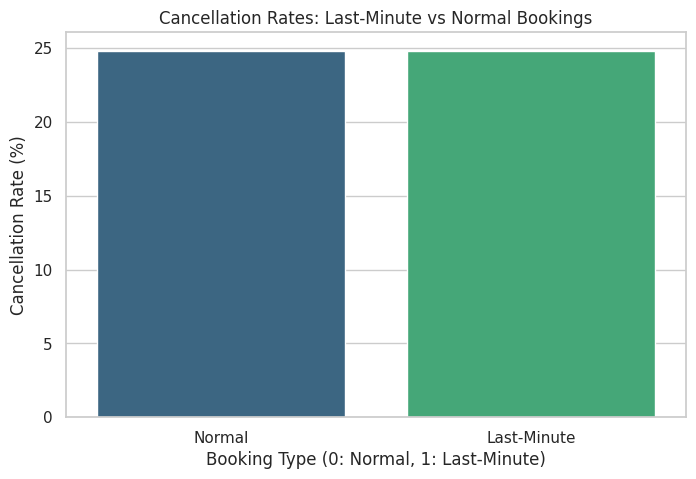

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the cancellation rates for last-minute vs normal bookings
plt.figure(figsize=(8, 5))
sns.barplot(x='Last_Minute_Booking', y='Cancellation_Rate (%)', data=cancellation_rate, palette='viridis')
plt.title('Cancellation Rates: Last-Minute vs Normal Bookings')
plt.xlabel('Booking Type (0: Normal, 1: Last-Minute)')
plt.ylabel('Cancellation Rate (%)')
plt.xticks([0, 1], ['Normal', 'Last-Minute'], rotation=0)
plt.show()


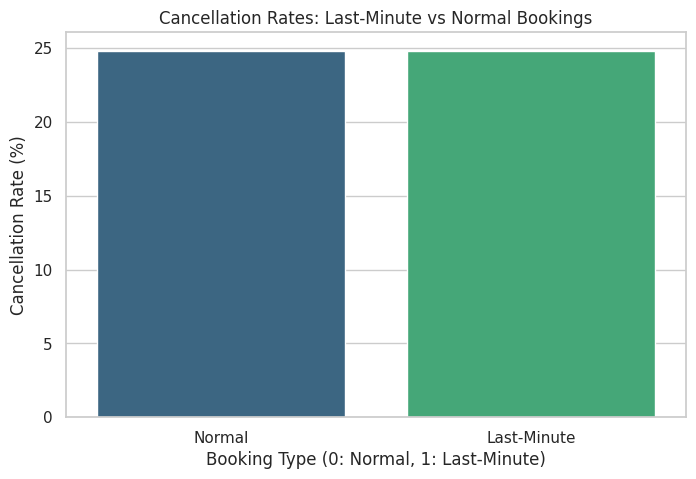

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the cancellation rates for last-minute vs normal bookings
plt.figure(figsize=(8, 5))
sns.barplot(x='Last_Minute_Booking', y='Cancellation_Rate (%)', data=cancellation_rate, palette='viridis', hue='Last_Minute_Booking', legend=False)
plt.title('Cancellation Rates: Last-Minute vs Normal Bookings')
plt.xlabel('Booking Type (0: Normal, 1: Last-Minute)')
plt.ylabel('Cancellation Rate (%)')
plt.xticks([0, 1], ['Normal', 'Last-Minute'], rotation=0)
plt.show()

In [ ]:
# Ensure 'property_id' in fact_bookings is string type for merging
fact_bookings['property_id'] = fact_bookings['property_id'].astype(str)

# Merge fact_bookings with dimensions
fact_bookings = (
    fact_bookings
    .merge(dim_hotels, on="property_id", how="left")                      # brings city
    .merge(dim_rooms, left_on="room_category", right_on="room_id", how="left")
    .merge(dim_date, left_on="check_in_date", right_on="date", how="left")
)

# Ensure 'property_id' in fact_aggregated is string type for merging
fact_aggregated['property_id'] = fact_aggregated['property_id'].astype(str)
# Ensure 'room_category' in fact_aggregated is string type for merging with dim_rooms
fact_aggregated['room_category'] = fact_aggregated['room_category'].astype(str)


# Merge fact_aggregated with dimensions
fact_aggregated = (
    fact_aggregated
    .merge(dim_hotels, on="property_id", how="left")
    .merge(dim_date, left_on="check_in_date", right_on="date", how="left")
    .merge(dim_rooms, left_on="room_category", right_on="room_id", how="left") # Added merge with dim_rooms
)

In [ ]:
fact_bookings["lead_time"] = (fact_bookings["check_in_date"] - fact_bookings["booking_date"]).dt.days
fact_bookings["cancellation"] = fact_bookings["booking_status"].eq("Cancelled")
fact_bookings["revenue_leakage"] = fact_bookings["revenue_generated"] - fact_bookings["revenue_realized"]
fact_bookings["leakage_percent"] = fact_bookings["revenue_leakage"] / fact_bookings["revenue_generated"] * 100
fact_bookings["booking_month"] = fact_bookings["booking_date"].dt.to_period("M")
fact_bookings["checkin_month"] = fact_bookings["check_in_date"].dt.to_period("M")


In [ ]:
def bucket_lead_time(days):
    if days <= 2: return "0-2 days"
    elif days <= 7: return "3-7 days"
    else: return "8+ days"

fact_bookings["lead_time_bucket"] = fact_bookings["lead_time"].apply(bucket_lead_time)



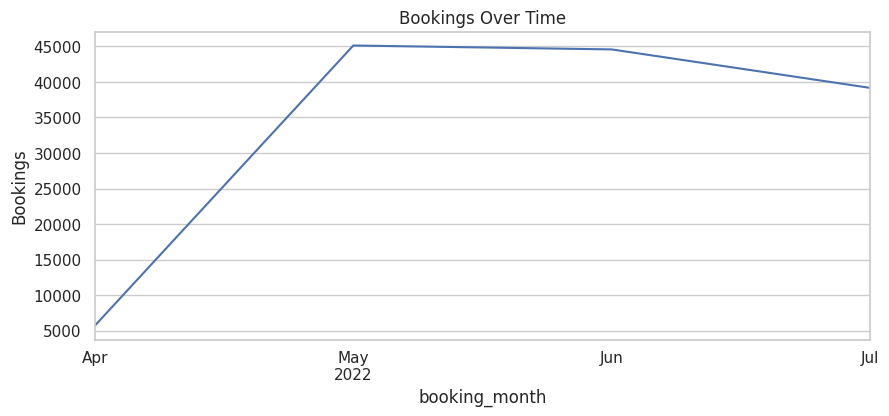

In [ ]:
fact_bookings.groupby("booking_month")["booking_id"].count().plot(figsize=(10,4), title="Bookings Over Time")
plt.ylabel("Bookings")
plt.show()

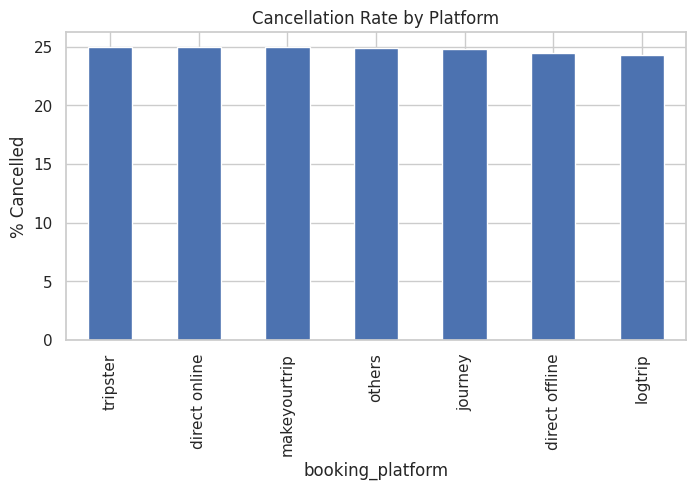

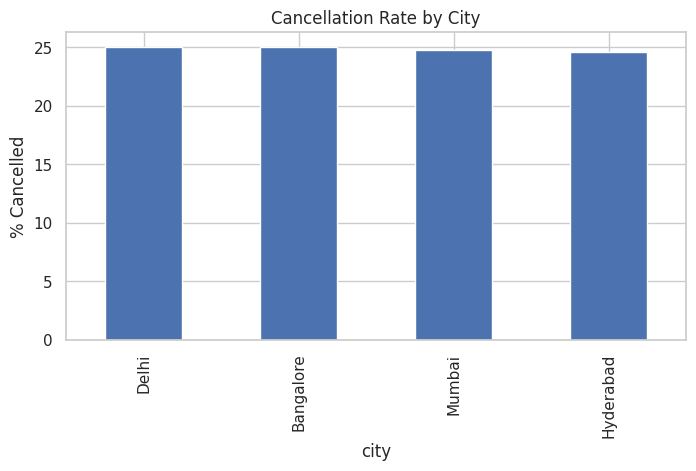

In [ ]:
# Cancellation by platform
cancel_platform = fact_bookings.groupby("booking_platform")["cancellation"].mean().sort_values(ascending=False) * 100
cancel_platform.plot(kind="bar", title="Cancellation Rate by Platform", figsize=(8,4))
plt.ylabel("% Cancelled")
plt.show()

# Cancellation by city
cancel_city = (
    fact_bookings.groupby("city")["booking_status"]
    .apply(lambda x: (x == "Cancelled").mean() * 100)
    .sort_values(ascending=False)
)
cancel_city.plot(kind="bar", title="Cancellation Rate by City", figsize=(8,4))
plt.ylabel("% Cancelled")
plt.show()


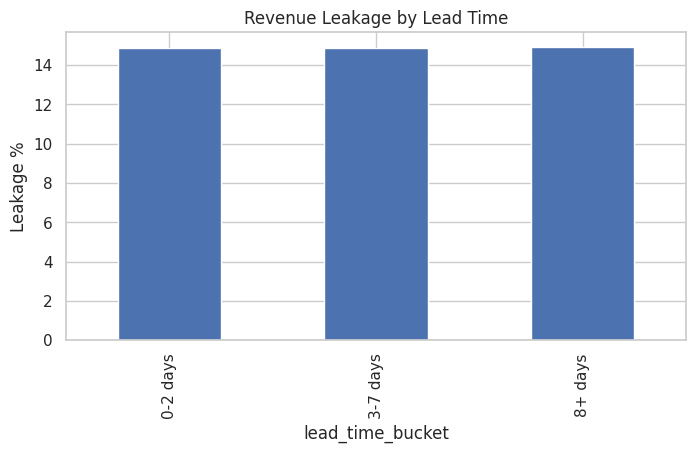

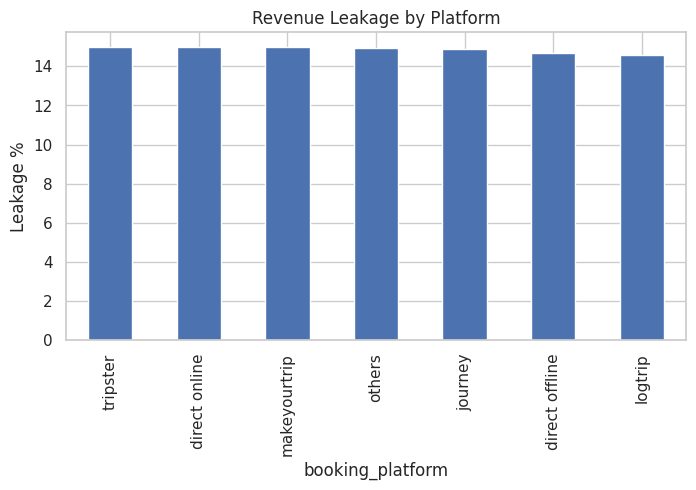

In [ ]:
leakage_lead = fact_bookings.groupby("lead_time_bucket")["leakage_percent"].mean()
leakage_lead.plot(kind="bar", title="Revenue Leakage by Lead Time", ylabel="Leakage %", figsize=(8,4))
plt.show()

leakage_platform = fact_bookings.groupby("booking_platform")["leakage_percent"].mean().sort_values(ascending=False)
leakage_platform.plot(kind="bar", title="Revenue Leakage by Platform", ylabel="Leakage %", figsize=(8,4))
plt.show()

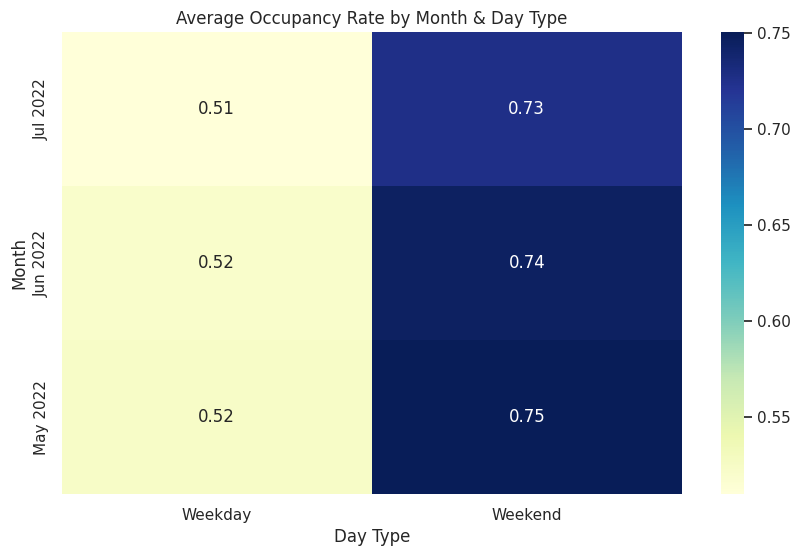

In [ ]:
# Ensure datetime column is properly parsed
fact_aggregated["check_in_date"] = pd.to_datetime(fact_aggregated["check_in_date"], errors='coerce')

# Create necessary columns
fact_aggregated["month"] = fact_aggregated["check_in_date"].dt.strftime("%b %Y")
fact_aggregated["day_of_week"] = fact_aggregated["check_in_date"].dt.dayofweek
fact_aggregated["day_type"] = fact_aggregated["day_of_week"].apply(lambda x: "Weekend" if x >= 5 else "Weekday")

# Calculate occupancy rate
fact_aggregated["occupancy_rate"] = fact_aggregated["successful_bookings"] / fact_aggregated["capacity"]

# Pivot table: Month vs Day Type
pivot = fact_aggregated.pivot_table(
    index="month",
    columns="day_type",
    values="occupancy_rate",
    aggfunc="mean"
).fillna(0)

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Occupancy Rate by Month & Day Type")
plt.xlabel("Day Type")
plt.ylabel("Month")
plt.show()

In [ ]:
# Check columns of fact_aggregated after merging with dim_rooms
print("Columns of fact_aggregated after merge with dim_rooms:")
print(fact_aggregated.columns)

# Check unique values in the columns used for merging
print("\nUnique values in fact_aggregated['room_category']:")
print(fact_aggregated['room_category'].unique())

print("\nUnique values in dim_rooms['room_id']:")
print(dim_rooms['room_id'].unique())

Columns of fact_aggregated after merge with dim_rooms:
Index(['property_id', 'check_in_date', 'room_category', 'successful_bookings',
       'capacity', 'property_name', 'category', 'city', 'date', 'mmm_yy',
       'week_no', 'day_type', 'room_id_x', 'room_class_x', 'month',
       'day_of_week', 'room_id_y', 'room_class_y', 'occupancy_rate'],
      dtype='object')

Unique values in fact_aggregated['room_category']:
['RT1' 'RT2' 'RT3' 'RT4']

Unique values in dim_rooms['room_id']:
['RT1' 'RT2' 'RT3' 'RT4']


In [ ]:
# Check that room_class is present after merge
if "room_class" not in fact_bookings.columns:
    print("room_class not found. Check your merge with dim_rooms.")
else:
    # Revenue comparison by room class
    fact_bookings.groupby("room_class")[["revenue_generated", "revenue_realized"]].mean().plot(
        kind="bar", title="Average Revenue by Room Class", figsize=(8,4))
    plt.ylabel("Revenue (INR)")
    plt.show()

    # Occupancy from fact_aggregated if room info is available
    if "room_category" in fact_aggregated.columns:
        # Ensure successful_bookings and capacity are numeric
        fact_aggregated["successful_bookings"] = pd.to_numeric(fact_aggregated["successful_bookings"], errors='coerce')
        fact_aggregated["capacity"] = pd.to_numeric(fact_aggregated["capacity"], errors='coerce')

        # Merge with dim_rooms and rename the room_class column
        fact_aggregated = fact_aggregated.merge(dim_rooms, left_on="room_category", right_on="room_id", how="left")
        # Check for 'room_class_x' or 'room_class_y' and rename to 'room_class'
        if 'room_class_y' in fact_aggregated.columns:
            fact_aggregated.rename(columns={'room_class_y': 'room_class'}, inplace=True)
        elif 'room_class_x' in fact_aggregated.columns:
             fact_aggregated.rename(columns={'room_class_x': 'room_class'}, inplace=True)


        fact_aggregated["occupancy_rate"] = fact_aggregated["successful_bookings"] / fact_aggregated["capacity"]
        room_occ = fact_aggregated.groupby("room_class")["occupancy_rate"].mean().sort_values()
        room_occ.plot(kind="bar", title="Average Occupancy Rate by Room Class", figsize=(8,4))
        plt.ylabel("Occupancy Rate")
        plt.show()
    else:
        print("room_category not found in fact_aggregated. Occupancy by room class skipped.")

room_class not found. Check your merge with dim_rooms.


In [ ]:
# Check what 'room_category' looks like in fact_bookings
print(fact_bookings["room_category"].unique())


['RT1' 'RT2' 'RT3' 'RT4']


In [ ]:
print(dim_rooms.columns.tolist())
print(dim_rooms["room_id"].unique())


['room_id', 'room_class']
['RT1' 'RT2' 'RT3' 'RT4']


In [ ]:
fact_bookings = fact_bookings.merge(
    dim_rooms.rename(columns={"room_id": "room_category_match"}),  # avoid column collision
    left_on="room_category", right_on="room_category_match", how="left"
)


In [ ]:
print(fact_bookings[["room_category", "room_class"]].drop_duplicates().head())


   room_category    room_class
0            RT1      Standard
18           RT2         Elite
39           RT3       Premium
47           RT4  Presidential


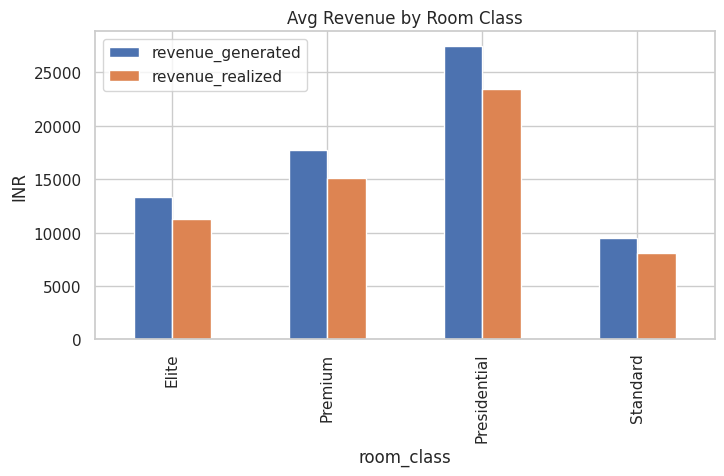

In [ ]:
fact_bookings.groupby("room_class")[["revenue_generated", "revenue_realized"]].mean().plot(
    kind="bar", title="Avg Revenue by Room Class", figsize=(8,4))
plt.ylabel("INR")
plt.show()


/tmp/ipython-input-2068468561.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fact_bookings.groupby("rating_bucket")[["revenue_generated", "revenue_realized"]].mean().plot(


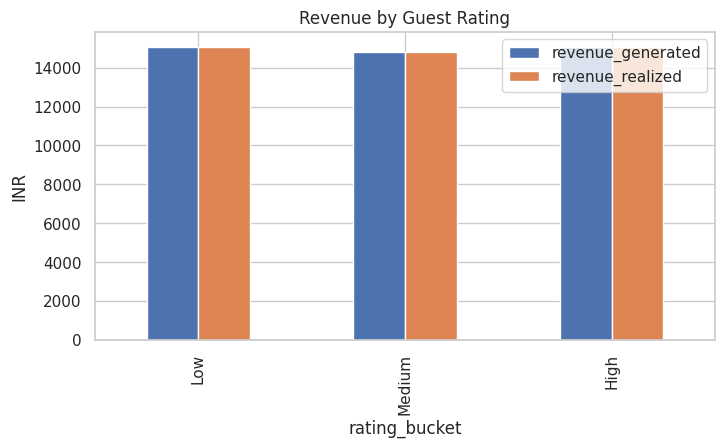

In [ ]:
fact_bookings["ratings_given"] = pd.to_numeric(fact_bookings["ratings_given"], errors="coerce")
fact_bookings["rating_bucket"] = pd.cut(fact_bookings["ratings_given"], bins=[0, 2, 4, 5], labels=["Low", "Medium", "High"])

fact_bookings.groupby("rating_bucket")[["revenue_generated", "revenue_realized"]].mean().plot(
    kind="bar", title="Revenue by Guest Rating", figsize=(8,4))
plt.ylabel("INR")
plt.show()

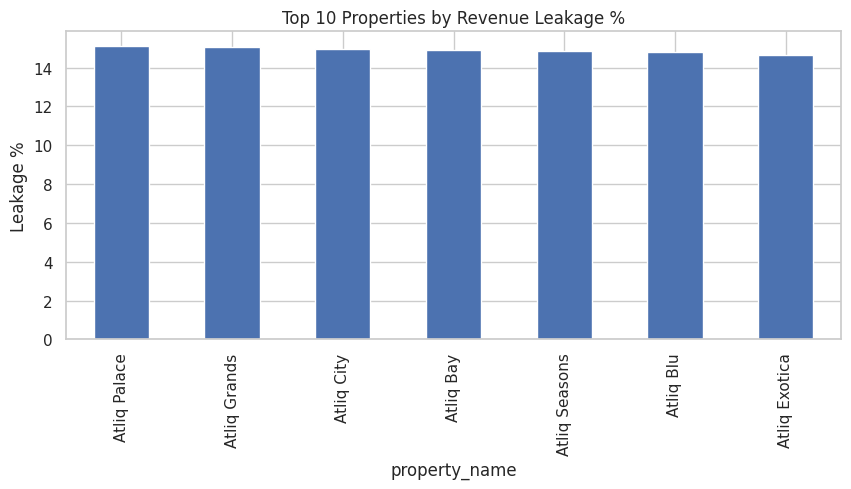

,cancellation,ratings_given,leakage_percent
booking_platform,,,
tripster,0.249948,3.620817,14.996885
direct online,0.249944,3.612289,14.996637
makeyourtrip,0.249907,3.615507,14.994423
others,0.248756,3.619019,14.925362
journey,0.247841,3.626659,14.870466
direct offline,0.244856,3.621784,14.691340
logtrip,0.243020,3.624620,14.581187


In [ ]:
# Top leaking properties
top_leak_props = fact_bookings.groupby("property_name")["leakage_percent"].mean().sort_values(ascending=False).head(10)
top_leak_props.plot(kind="bar", figsize=(10, 4), title="Top 10 Properties by Revenue Leakage %")
plt.ylabel("Leakage %")
plt.show()

# High cancellation + low rating
combo = fact_bookings.groupby("booking_platform").agg({
    "cancellation": "mean",
    "ratings_given": "mean",
    "leakage_percent": "mean"
}).sort_values(by="cancellation", ascending=False)

display(combo.style.background_gradient(cmap="OrRd"))

In [ ]:
fact_bookings.columns.tolist()


['booking_id',
 'property_id',
 'booking_date',
 'check_in_date',
 'checkout_date',
 'no_guests',
 'room_category',
 'booking_platform',
 'ratings_given',
 'booking_status',
 'revenue_generated',
 'revenue_realized',
 'lead_time',
 'last_minute_booking',
 'property_name',
 'category',
 'city',
 'room_id',
 'room_class_x',
 'date',
 'mmm_yy',
 'week_no',
 'day_type',
 'cancellation',
 'revenue_leakage',
 'leakage_percent',
 'booking_month',
 'checkin_month',
 'lead_time_bucket',
 'room_category_match_x',
 'room_class_y',
 'room_category_match_y',
 'room_class',
 'rating_bucket']

In [ ]:
# Try to detect an available guest identifier
possible_ids = ["guest_email", "booking_contact", "guest_name", "user_id"]
guest_id_column = None

for col in possible_ids:
    if col in fact_bookings.columns:
        guest_id_column = col
        break

if guest_id_column:
    print(f"Using guest identifier: {guest_id_column}")
    repeat_guests = fact_bookings.groupby(guest_id_column)["booking_id"].count()
    repeat_guest_rate = (repeat_guests > 1).mean() * 100
    print(f"🔁 Repeat Guest Rate: {repeat_guest_rate:.2f}%")

    # Optional: Plot distribution of repeats
    repeat_guests.value_counts().sort_index().head(10).plot(
        kind="bar", title="Repeat Booking Frequency (Top 10)", figsize=(8,4))
    plt.xlabel("Number of Bookings per Guest")
    plt.ylabel("Number of Guests")
    plt.show()
else:
    print("❌ No guest-level identifier available to calculate repeat booking rate.")


❌ No guest-level identifier available to calculate repeat booking rate.


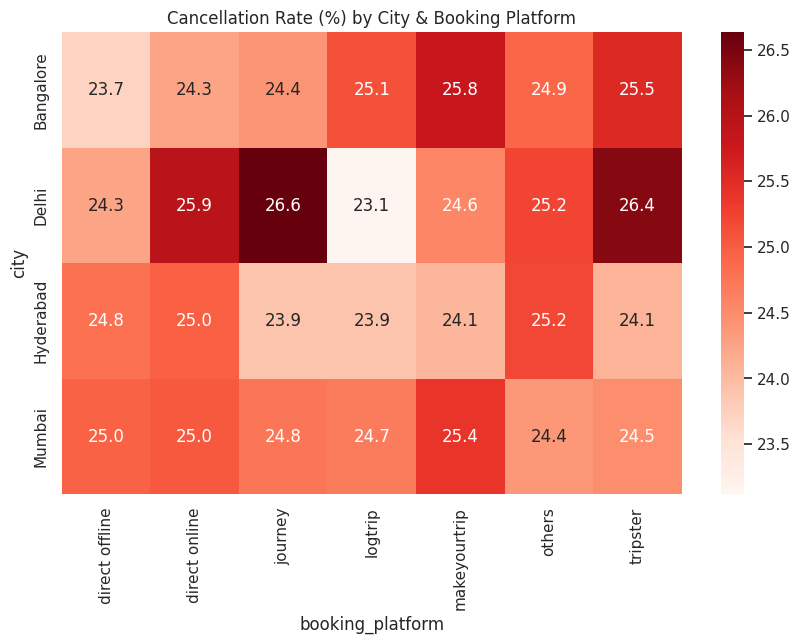

In [ ]:
city_platform_cancel = fact_bookings.pivot_table(
    index="city", columns="booking_platform",
    values="cancellation", aggfunc="mean"
).fillna(0) * 100

import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(city_platform_cancel, annot=True, fmt=".1f", cmap="Reds")
plt.title("Cancellation Rate (%) by City & Booking Platform")
plt.show()


In [ ]:
current_loss = fact_bookings["revenue_leakage"].sum()

# Assume 10% fewer cancellations
hypothetical_cancellation_rate = fact_bookings["cancellation"].mean() * 0.9
average_loss_per_cancel = fact_bookings[fact_bookings["cancellation"] == True]["revenue_leakage"].mean()
potential_savings = len(fact_bookings) * (fact_bookings["cancellation"].mean() - hypothetical_cancellation_rate) * average_loss_per_cancel

print(f"💸 Current Revenue Leakage: ₹{current_loss:,.0f}")
print(f"✅ Potential Revenue Gain if Cancellations Drop 10%: ₹{potential_savings:,.0f}")

💸 Current Revenue Leakage: ₹298,774,986
✅ Potential Revenue Gain if Cancellations Drop 10%: ₹29,877,499
